In [62]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia
rF_FF, rF_BF = sym.symbols(['r_{F_{FF}}','r_{F_{BF}}']) # distance of feet from COM. 

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# forces
GRF_BW,GRF_FW = sym.symbols(['GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_BFx,F_BFy = sym.symbols(['F_{BFx}','F_{BFy}']) # back foot applied forces
F_FFx,F_FFy = sym.symbols(['F_{FFx}','F_{FFy}']) # front foot applied forces

# STEP 1: position vectors ri = [x,y] (world frame)
rb = sym.Matrix([[x],
                [y]])
# the Jacobians
Jb = rb.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([mb,mb])

T = 0.5*sym.transpose(Mb)*sym.matrix_multiply_elementwise(vb,vb)
T = T[0] + 0.5*Inb*dthb**2
V = mb*g*rb[1]

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# term 5 - generalized forces
# applied forces
F_bf = sym.Matrix([[F_BFx],[-F_BFy]])
F_ff = sym.Matrix([[F_FFx],[-F_FFy]])

# ground forces acting on the board
GRF_bw = sym.Matrix([[0],[GRF_BW]])
GRF_fw = sym.Matrix([[0],[GRF_FW]])

# distance of forces
rGRF_bw = sym.Matrix([[x - 0.5*lbr*sym.cos(thb)+hb*sym.sin(thb)],
                      [y - 0.5*lbr*sym.sin(thb)-hb*sym.cos(thb)]])

rGRF_fw = sym.Matrix([[x + 0.5*lbr*sym.cos(thb)+hb*sym.sin(thb)],
                      [y + 0.5*lbr*sym.sin(thb)-hb*sym.cos(thb)]])

JGRF_bw = rGRF_bw.jacobian(q)
JGRF_fw = rGRF_fw.jacobian(q)

# applied forces on the board
rF_bf = sym.Matrix([[x - rF_BF*sym.cos(thb)],
                    [y - rF_BF*sym.sin(thb)]])

rF_ff = sym.Matrix([[x + rF_FF*sym.cos(thb)],
                    [y + rF_FF*sym.sin(thb)]])

JF_bf = rF_bf.jacobian(q)
JF_ff = rF_ff.jacobian(q)

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = GRF_bw.transpose()*JGRF_bw[:,j]+GRF_fw.transpose()*JGRF_fw[:,j]+F_bf.transpose()*JF_bf[:,j]+F_ff.transpose()*JF_ff[:,j]

# Calculate equations of motion
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
     EOMs[j] = EOM[j].simplify()

#display(sym.solve(EOMs, [ddq[0],ddq[1],ddq[2]]))


In [63]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            rF_BF,rF_FF,
            F_BFx,F_BFy,F_FFx,F_FFy,
            GRF_BW,GRF_FW]
            
lambEOMx   = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOMy   = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOMthb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])

In [64]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 30
m.N = RangeSet(N)

N1 = 10 # end of phase 1
# N2 = 20 # end of phase 2
# N3 = 40 # end of phase 3

hm  = 0.02 #master timestep

DOFs = ['x','y','thb'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BFx','BFy','FFx','FFy'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

rFs = ['BF','FF'] # front foot, backfoot
m.rFs = Set(initialize = rFs) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 2.0) # mass of board
m.lb = Param(initialize = 0.80) # length of board
m.lbr = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hb = Param(initialize = 0.09) # board clearance
#m.mhuman = Param(initialize = 70.0) # human weight
#m.etail = Param(initialize = -1.0) # coefficient of restitution of tail
#m.ewheels = Param(initialize = 0.0) # coefficient of restitution of tail

m.Inb = Param(initialize = 1/12*m.mb*m.lb**2) # moment of inertia about centre

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# forces
m.F = Var(m.N, m.Fs, bounds = (0.0, None)) # Force from front foot > 0
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, None)) # Ground reaction force on back wheel

# radius of applied forces from COM
m.rF = Var(m.N, m.rFs, bounds = (0.0, 0.5*m.lb))

# auxillary variables
m.ptail = Var(m.N, m.DOF) # back of board
m.pnose = Var(m.N, m.DOF) # front of board
m.pbackwheel = Var(m.N, m.DOF) # position of backwheel
m.pfrontwheel = Var(m.N, m.DOF) # position of frontwheel
m.vtail = Var(m.N, m.DOF) # velocity of back of board

def def_ptail(m,n,dof):
    if dof == 'x':
        return m.ptail[n, 'x'] == m.q[n,'x'] - 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.ptail[n, 'y'] == m.q[n,'y'] - 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.DOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'x':
        return m.pnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.pnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.DOF,rule = def_pnose)

def def_pbackwheel(m,n,dof):
    if dof == 'x':
        return m.pbackwheel[n, 'x'] == m.q[n,'x']-0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pbackwheel[n, 'y'] == m.q[n,'y']-0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pbackwheel = Constraint(m.N, m.DOF,rule = def_pbackwheel)

def def_pfrontwheel(m,n,dof):
    if dof == 'x':
        return m.pfrontwheel[n, 'x'] == m.q[n,'x']+0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])    
    if dof == 'y':
        return m.pfrontwheel[n, 'y'] == m.q[n,'y']+0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pfrontwheel = Constraint(m.N, m.DOF,rule = def_pfrontwheel)

def def_vtail(m,n,dof):
    if dof == 'y':
        return m.vtail[n, 'y'] == m.dq[n,'y']-m.dq[n,'thb']*0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.DOF,rule = def_vtail)

# bound variables
for n in range(1,N+1):
    m.pnose[n,'y'].setlb(0.0)
    m.ptail[n,'y'].setlb(0.0)
    m.pbackwheel[n,'y'].setlb(0.0)
    m.pfrontwheel[n,'y'].setlb(0.0)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thb'].setlb(-np.pi/2)

# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# SWITCHING CONSTRAINT AT IMPACT ----------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------------------
# EOMs 
# -----------------------------------------------------------------------------------------------------------------------------

def EOMx(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               m.F[n,'BFx'], m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
               m.GRF[n,'BW'], m.GRF[n,'FW']]
    return lambEOMx(*var_list) == 0
m.EOMx = Constraint(m.N, rule = EOMx)

def EOMy(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               m.F[n,'BFx'], m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
               m.GRF[n,'BW'], m.GRF[n,'FW']]
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

def EOMthb(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               m.F[n,'BFx'], m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
               m.GRF[n,'BW'], m.GRF[n,'FW']] 
    return lambEOMthb(*var_list) == 0
m.EOMthb = Constraint(m.N, rule = EOMthb)

In [65]:
# OTHER CONSTRAINTS -----------------------------------------------------------------------------------------------------------

def def_GRF(m,n,grf): # for when wheels in contact with the ground
#     if grf == 'BW':
#         return m.GRF[n,'BW'] == 0.0
    if n>=N1-1:
        if grf == 'FW':
            return m.GRF[n,'FW'] == 0.0 
            #return Constraint.Skip
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_GRF = Constraint(m.N, m.GRFs, rule = def_GRF)

def def_pFixWheels(m,n,grf): # for fixing wheels to the ground
    if grf == 'BW':
        return m.pbackwheel[n,'y'] == 0
    if grf == 'FW':
        if n<N1:
            return m.pfrontwheel[n,'y'] == 0
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_pFixWheels = Constraint(m.N, m.GRFs,rule = def_pFixWheels)

for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
for fs in Fs:
    m.F[N, fs].fix(0.0)
for rfs in rFs:
    m.rF[N, rfs].fix(0.0)

In [66]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------
# minimum time and minimum reaction penalties

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    force_sum = 0
    for n in range(1,N+1):
        for fs in Fs:
            force_sum += m.F[n,fs]
    return T+1000*force_sum
m.Cost = Objective(rule = CostFun)

In [67]:
# OLLIE MANOEUVRE -----------------------------------------------------------------------------------------------------------

# On the ground

m.q[1,'x'].fix(0.0)
m.pbackwheel[1,'y'].fix(0.0)
m.q[1,'thb'].fix(0.0)

m.dq[1,'x'].fix(0.0)
m.dq[1,'y'].fix(0.0)
m.dq[1,'thb'].fix(0.0)

m.pbackwheel[N1,'y'].fix(0.0)
m.q[N1,'thb'].fix(0.0)
m.dq[N1,'x'].fix(0.0)
m.dq[N1,'y'].fix(0.0)
m.dq[N1,'thb'].fix(0.0)

m.ptail[N,'y'].fix(0.0)
m.pbackwheel[N,'y'].fix(0.0)
m.vtail[N,'x'].setlb(10.0)

for n in range(1,N+1):
    for rfs in rFs:
        m.rF[n,rfs].fix(0.5*m.lb)

In [68]:
# # In-Flight

# m.q[1,'x'].fix(0.0)
# m.ptail[1,'y'].fix(0.0)
# m.pbackwheel[1,'y'].fix(0.0)

# m.dq[1,'x'].fix(0.0)
# m.dq[1,'thb'].fix(0.0)

# m.pbackwheel[N,'y'].fix(0.0)
# m.pfrontwheel[N,'y'].fix(0.0)
# m.q[N,'thb'].fix(0.0)

# for n in range(1,N+1):
#     for rfs in rFs:
#         m.rF[n,rfs].fix(0.5*m.lb)

In [69]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 50000 # maximum number of iterations
opt.options["max_cpu_time"] = 10*60 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee=False) 

print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.
warning
maxIterations


In [70]:
#m.pfrontwheel.pprint()

In [71]:
maxForce = 0
maxGRF = 0
for i in range(1,N+1):
    for fs in Fs:
        if m.F[i,fs].value>maxForce:
            maxForce = m.F[i,fs].value
    for grf in GRFs:
        if m.GRF[i,grf].value is not None: 
            if m.GRF[i,grf].value>maxGRF:
                 maxGRF = m.GRF[i,grf].value

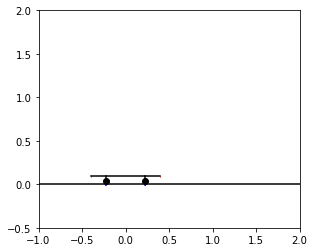

In [72]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,2])
    ax.set_ylim([-0.5,2.0])
    
    #plot ground
    groundLx = -1
    groundLy = 0
    groundRx = 2
    groundRy = 0
    ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=6)
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=6)
    
    #plot forces
    backforcex = m.q[i,'x'].value - m.rF[i,'BF'].value*cos(m.q[i,'thb'].value)
    backforcey = m.q[i,'y'].value - m.rF[i,'BF'].value*sin(m.q[i,'thb'].value)
    frontforcex = m.q[i,'x'].value + m.rF[i,'FF'].value*cos(m.q[i,'thb'].value)
    frontforcey = m.q[i,'y'].value + m.rF[i,'FF'].value*sin(m.q[i,'thb'].value)
    
    if maxForce!=0:
        magforceBFy = m.F[i,'BFy'].value/maxForce
        magforceFFy = m.F[i,'FFy'].value/maxForce 
        magforceBFx = m.F[i,'BFx'].value/maxForce
        magforceFFx = m.F[i,'FFx'].value/maxForce 
#     magforceBFy = 1
#     magforceFFy = 1
#     magforceBFx = 1
#     magforceFFx = 1

        ax.arrow(backforcex, backforcey+magforceBFy*0.5,0,-magforceBFy*0.5, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
        ax.arrow(frontforcex, frontforcey+magforceFFy*0.5,0,-magforceFFy*0.5, length_includes_head=True,head_width=magforceFFy*0.05,color='red')

        ax.arrow(backforcex-magforceBFx*0.5, backforcey,magforceBFx*0.5,0, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
        ax.arrow(frontforcex-magforceFFx*0.5,frontforcey,magforceFFx*0.5,0, length_includes_head=True,head_width=magforceFFy*0.05,color='red')
    
    
    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0
        
    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1, update, frames=range(1,N+1), interval=100, repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


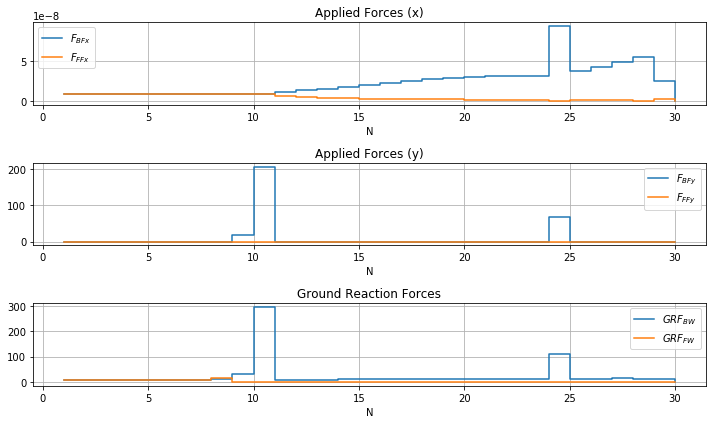

In [73]:
# Plot some of the variables
F_BFxar = [m.F[i,'BFx']() for i in range(1,N+1)]
F_FFxar  = [m.F[i,'FFx']() for i in range (1,N+1)]
F_BFyar = [m.F[i,'BFy']() for i in range(1,N+1)]
F_FFyar  = [m.F[i,'FFy']() for i in range (1,N+1)]
GRF_BWar = [m.GRF[i,'BW']() for i in range(1,N+1)]
GRF_FWar = [m.GRF[i,'FW']() for i in range(1,N+1)]

# tarr = [m.h[i]() for i in range (1,N+1)]
# t = hm*np.cumsum(np.asarray(tarr))
# t -= t[0]

nar = np.linspace(1,N,N)

plt.figure(figsize=(10, 6))
plt.subplot(3,1,1)
plt.step(nar, F_BFxar,where='post')
plt.step(nar, F_FFxar,where='post')
plt.title('Applied Forces (x)')
plt.xlabel('N')
plt.legend([r'$F_{BFx}$',r'$F_{FFx}$'])
plt.grid(True)

plt.subplot(3,1,2)
plt.step(nar, F_BFyar,where='post')
plt.step(nar, F_FFyar,where='post')
plt.title('Applied Forces (y)')
plt.xlabel('N')
plt.legend([r'$F_{BFy}$',r'$F_{FFy}$'])
plt.grid(True)

plt.subplot(3,1,3)
plt.step(nar, GRF_BWar,where='post')
plt.step(nar, GRF_FWar,where='post')
plt.title('Ground Reaction Forces')
plt.xlabel('N')
plt.legend([r'$GRF_{BW}$',r'$GRF_{FW}$'])
plt.grid(True)


# plt.subplot(3,1,3)
# plt.step(nar,tarr,where ='post')
# plt.title('Variable Time')
# plt.xlabel('N')
# plt.ylabel('Time steps')
# plt.grid(True)
# plt.ylim([0.7,1.3])

plt.tight_layout()

In [77]:
#m.vtail.pprint()

In [75]:
# # store all variables for extrapolation
# from scipy.interpolate import interp1d

# #initialize time dependent arrays
# q_x_ar = np.zeros(N)
# q_y_ar = np.zeros(N)
# q_thb_ar = np.zeros(N)

# ptail_x_ar = np.zeros(N)
# ptail_y_ar = np.zeros(N)
# pnose_x_ar = np.zeros(N)
# pnose_y_ar = np.zeros(N)

# pbackwheel_x_ar = np.zeros(N)
# pbackwheel_y_ar = np.zeros(N)
# pfrontwheel_x_ar = np.zeros(N)
# pfrontwheel_y_ar = np.zeros(N)

# F_FF_ar = np.zeros(N)
# F_BF_ar = np.zeros(N)

# rF_FF_ar = np.zeros(N)
# rF_BF_ar = np.zeros(N)

# GRF_FW_ar = np.zeros(N)
# GRF_BW_ar = np.zeros(N)
# h_ar = np.zeros(N)

# # fill arrays with solver values
# for i in range (1,N+1):
#     q_x_ar[i-1]    = m.q[i,'x'].value
#     q_y_ar[i-1]    = m.q[i,'y'].value
#     q_thb_ar[i-1]  = m.q[i,'thb'].value

#     ptail_x_ar[i-1] = m.ptail[i,'x'].value
#     ptail_y_ar[i-1] = m.ptail[i,'y'].value
#     pnose_x_ar[i-1] = m.pnose[i,'x'].value
#     pnose_y_ar[i-1] = m.pnose[i,'y'].value
    
#     pbackwheel_x_ar[i-1] = m.pbackwheel[i,'x'].value
#     pbackwheel_y_ar[i-1] = m.pbackwheel[i,'y'].value
#     pfrontwheel_x_ar[i-1] = m.pfrontwheel[i,'x'].value
#     pfrontwheel_y_ar[i-1] = m.pfrontwheel[i,'y'].value
    
#     F_FF_ar[i-1] = m.F[i,'FF'].value
#     F_BF_ar[i-1] = m.F[i,'BF'].value
    
#     rF_FF_ar[i-1] = m.rF[i,'FF'].value
#     rF_BF_ar[i-1] = m.rF[i,'BF'].value
    
#     GRF_FW_ar[i-1] = m.GRF[i,'FW'].value
#     GRF_BW_ar[i-1] = m.GRF[i,'BW'].value
    
#     h_ar[i-1] = m.h[i].value*hm

# # calculate the time array. 
# t_ar = np.cumsum(h_ar)

# # caculate the interpolation functions.
# f_x_interp = interp1d(t_ar, q_x_ar, kind='cubic')
# f_y_interp = interp1d(t_ar, q_y_ar, kind='cubic')
# f_thb_interp = interp1d(t_ar, q_thb_ar, kind='cubic')

# f_ptail_x_interp = interp1d(t_ar, ptail_x_ar, kind='cubic')
# f_ptail_y_interp = interp1d(t_ar, ptail_y_ar, kind='cubic')
# f_pnose_x_interp = interp1d(t_ar, pnose_x_ar, kind='cubic')
# f_pnose_y_interp = interp1d(t_ar, pnose_y_ar, kind='cubic')

# f_pbackwheel_x_interp = interp1d(t_ar, pbackwheel_x_ar, kind='cubic')
# f_pbackwheel_y_interp = interp1d(t_ar, pbackwheel_y_ar, kind='cubic')
# f_pfrontwheel_x_interp = interp1d(t_ar, pfrontwheel_x_ar, kind='cubic')
# f_pfrontwheel_y_interp = interp1d(t_ar, pfrontwheel_y_ar, kind='cubic')

# f_F_FF_interp = interp1d(t_ar, F_FF_ar, kind='next')
# f_F_BF_interp = interp1d(t_ar, F_BF_ar, kind='next')

# rf_F_FF_interp = interp1d(t_ar, F_FF_ar, kind='next')
# rf_F_BF_interp = interp1d(t_ar, F_BF_ar, kind='next')

# f_GRF_FW_interp = interp1d(t_ar, GRF_FW_ar, kind='next')
# f_GRF_BW_interp = interp1d(t_ar, GRF_BW_ar, kind='next')

# # the desired time steps of 0.01s (100Hz)
# Ts = hm
# t_d = np.arange(0.02, t_ar[-1], Ts)

# # sample the interpolation functions at 50Hz.
# q_x_interp = f_x_interp(t_d)
# q_y_interp = f_y_interp(t_d)
# q_thb_interp = f_thb_interp(t_d)

# ptail_x_interp = f_ptail_x_interp(t_d)
# ptail_y_interp = f_ptail_y_interp(t_d)
# pnose_x_interp = f_pnose_x_interp(t_d)
# pnose_y_interp = f_pnose_y_interp(t_d)

# pbackwheel_x_interp = f_pbackwheel_x_interp(t_d)
# pbackwheel_y_interp = f_pbackwheel_y_interp(t_d)
# pfrontwheel_x_interp = f_pfrontwheel_x_interp(t_d)
# pfrontwheel_y_interp = f_pfrontwheel_y_interp(t_d)

# F_FF_interp = f_F_FF_interp(t_d)
# F_BF_interp = f_F_BF_interp(t_d)

# rF_FF_interp = rf_F_FF_interp(t_d)
# rF_BF_interp = rf_F_BF_interp(t_d)

# GRF_FW_interp = f_GRF_FW_interp(t_d)
# GRF_BW_interp = f_GRF_BW_interp(t_d)

# # number of samples
# N_interp = len(t_d) 

In [76]:
# #animate it
# import matplotlib.pyplot as plt
# import matplotlib.animation as ani
# from IPython.display import HTML
# %matplotlib inline

# fig1, ax1 = plt.subplots(1,1) #create axes
# ax1.set_aspect('equal')

# def plot_board(i,m,ax): #update function for animation
#     ax.clear()
#     ax1.set_title('Ollie Manoeuvre in Real Time')
#     ax.set_xlim([-0.5,2])
#     ax.set_ylim([-0.5,1.5])
    
#     #plot ground
#     groundLx = -1
#     groundLy = 0
#     groundRx = 2.0
#     groundRy = 0
#     ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
#     #plot skateboard
#     boardLx = ptail_x_interp[i]
#     boardLy = ptail_y_interp[i]
#     boardRx = pnose_x_interp[i]
#     boardRy = pnose_y_interp[i]
#     ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
#     #plot left wheel
#     leftwheelTopx = q_x_interp[i]-0.5*m.lbr*np.cos(q_thb_interp[i])
#     leftwheelTopy = q_y_interp[i]-0.5*m.lbr*np.sin(q_thb_interp[i])
#     leftwheelBottomx = pbackwheel_x_interp[i]
#     leftwheelBottomy = pbackwheel_y_interp[i]
#     ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
#     #plot left wheel-wheel
#     leftwheelx = q_x_interp[i]-0.5*m.lbr*cos(q_thb_interp[i])+0.6*m.hb*sin(q_thb_interp[i])
#     leftwheely = q_y_interp[i]-0.5*m.lbr*sin(q_thb_interp[i])-0.6*m.hb*cos(q_thb_interp[i])
#     ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=8)
    
#     #plot right wheel
#     rightwheelTopx = q_x_interp[i]+0.5*m.lbr*np.cos(q_thb_interp[i])
#     rightwheelTopy = q_y_interp[i]+0.5*m.lbr*np.sin(q_thb_interp[i])
#     rightwheelBottomx = pfrontwheel_x_interp[i]
#     rightwheelBottomy = pfrontwheel_y_interp[i]
#     ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
#     #plot right wheel-wheel
#     rightwheelx = q_x_interp[i]+0.5*m.lbr*cos(q_thb_interp[i])+0.6*m.hb*sin(q_thb_interp[i])
#     rightwheely = q_y_interp[i]+0.5*m.lbr*sin(q_thb_interp[i])-0.6*m.hb*cos(q_thb_interp[i])
#     ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=8)
    
# #     #plot forces
# #     magforceBF = 1#F_BF_interp[i]/maxForce
# #     magforceFF = 1#F_FF_interp[i]/maxForce
    
# #     backforcex = q_x_interp[i] - rF_BF_interp[i]*cos(q_thb_interp[i])
# #     backforcey = q_y_interp[i] - rF_BF_interp[i]*sin(q_thb_interp[i])
# #     frontforcex = q_x_interp[i] + rF_FF_interp[i]*cos(q_thb_interp[i])
# #     frontforcey = q_y_interp[i] + rF_FF_interp[i]*sin(q_thb_interp[i])        

# #     ax.arrow(backforcex, backforcey+magforceBF*0.5,0,-magforceBF*0.5, length_includes_head=True,head_width=magforceBF*0.05,color='red')
# #     ax.arrow(frontforcex, frontforcey+magforceFF*0.5,0,-magforceFF*0.5, length_includes_head=True,head_width=magforceFF*0.05,color='red')
    
# #     #plot GRF's
# #     if GRF_BW_interp[i] is not None:
# #         magGRFBW = GRF_BW_interp[i]/maxGRF
# #     else: 
# #         magGRFBW = 0
# #     if GRF_FW_interp[i] is not None:
# #         magGRFFW = GRF_FW_interp[i]/maxGRF
# #     else: 
# #         magGRFFW = 0
        
# #     backGRFx = leftwheelBottomx
# #     backGRFy = leftwheelBottomy
# #     frontGRFx = rightwheelBottomx
# #     frontGRFy = rightwheelBottomy        

# #     ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
# #     ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

# update = lambda i: plot_board(i,m,ax1) #lambdify update function

# # animate it - interval is in ms
# animate = ani.FuncAnimation(fig1,update,frames=range(0,N_interp),interval=Ts*1000,repeat=True)

# HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
